In [18]:
# Bike Demand Prediction + Feature Engineering + KerasTuner 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from keras import models, layers, Input, callbacks, regularizers
from keras.losses import Huber
from keras.models import load_model
import tensorflow as tf

In [20]:
# Load and preprocess data
df = pd.read_csv(r"C://Users//91888//Downloads//Daily Bike Sharing.csv")
df['dteday'] = pd.to_datetime(df['dteday'])
df['day'] = df['dteday'].dt.day

In [21]:
df.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,1
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,2
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,3
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,4
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,5


In [22]:
# Additional features
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x in [0, 6] else 0)
df['week_of_year'] = df['dteday'].dt.isocalendar().week.astype(int)
df['cnt_lag1'] = df['cnt'].shift(1).fillna(method='bfill')
df['cnt_rolling_3'] = df['cnt'].rolling(3).mean().fillna(method='bfill')

C:\Users\91888\AppData\Local\Temp\ipykernel_33044\1900638960.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['cnt_lag1'] = df['cnt'].shift(1).fillna(method='bfill')
C:\Users\91888\AppData\Local\Temp\ipykernel_33044\1900638960.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['cnt_rolling_3'] = df['cnt'].rolling(3).mean().fillna(method='bfill')


In [23]:
# Drop unneeded columns
df.drop(['instant', 'dteday', 'yr', 'casual', 'registered'], axis=1, inplace=True)

In [24]:
# Categorical and numerical features
categorical_features = ['season', 'mnth', 'weekday', 'weathersit']
numerical_features = [col for col in df.columns if col not in categorical_features + ['cnt']]
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['season', 'mnth', 'weekday', 'weathersit']
Numerical Features: ['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'day', 'is_weekend', 'week_of_year', 'cnt_lag1', 'cnt_rolling_3']


In [25]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

In [26]:
# Split data
X = df.drop('cnt', axis=1)
y = df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Transform inputs
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [28]:
# Build and train neural network
model = models.Sequential([
    Input(shape=(X_train_processed.shape[1],)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss=Huber(), metrics=['mae'])
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train_processed, y_train,
    validation_data=(X_test_processed, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4561.7109 - mae: 4562.0757 - val_loss: 4274.4697 - val_mae: 4274.8350
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4615.6016 - mae: 4615.9658 - val_loss: 4264.8369 - val_mae: 4265.1973
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4608.1450 - mae: 4608.5015 - val_loss: 4240.8989 - val_mae: 4241.2417
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4434.6260 - mae: 4434.9634 - val_loss: 4189.9941 - val_mae: 4190.3062
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4629.5854 - mae: 4629.8867 - val_loss: 4097.3740 - val_mae: 4097.6357
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4240.5791 - mae: 4240.8242 - val_loss: 3947.7593 - val_mae: 3947.9482
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4161.7275 - mae: 4161.8936 - val_loss: 3725.2551 - val_mae: 3725.3479
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3825.3040 - mae: 3825.3687 - v

In [29]:
# Predict
y_pred_nn = model.predict(X_test_processed).flatten()
y_pred_nn_train = model.predict(X_train_processed).flatten()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [30]:
# Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rf_train = rf.predict(X_train)

In [31]:
# Ensemble predictions
y_pred_ensemble = 0.5 * y_pred_nn + 0.5 * y_pred_rf
y_pred_ensemble_train = 0.5 * y_pred_nn_train + 0.5 * y_pred_rf_train

In [32]:
# Evaluation
print("\n--- Train Data ---")
print("NN MAE:", mean_absolute_error(y_train, y_pred_nn_train))
print("RF MAE:", mean_absolute_error(y_train, y_pred_rf_train))
print("Ensemble MAE:", mean_absolute_error(y_train, y_pred_ensemble_train))
print("Ensemble R²:", r2_score(y_train, y_pred_ensemble_train))

print("\n--- Test Data ---")
print("NN MAE:", mean_absolute_error(y_test, y_pred_nn))
print("RF MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Ensemble MAE:", mean_absolute_error(y_test, y_pred_ensemble))
print("Ensemble R²:", r2_score(y_test, y_pred_ensemble))


--- Train Data ---
NN MAE: 487.3140102151322
RF MAE: 156.31785958904112
Ensemble MAE: 305.327318936962
Ensemble R²: 0.950593482998715

--- Test Data ---
NN MAE: 533.2410564811862
RF MAE: 423.8632653061224
Ensemble MAE: 445.1483406077274
Ensemble R²: 0.9062479615075307


In [33]:
# Save and load model
model.save("bike_model_final.h5")
# model = load_model("bike_model_final.h5", custom_objects={'Huber': Huber()})

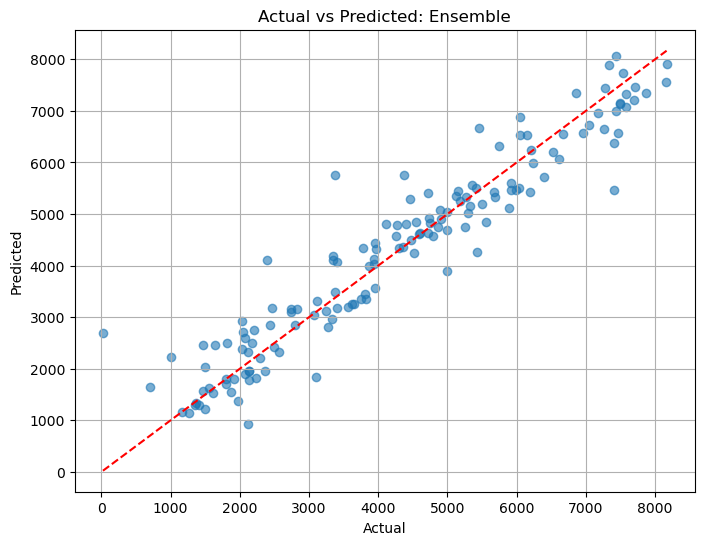

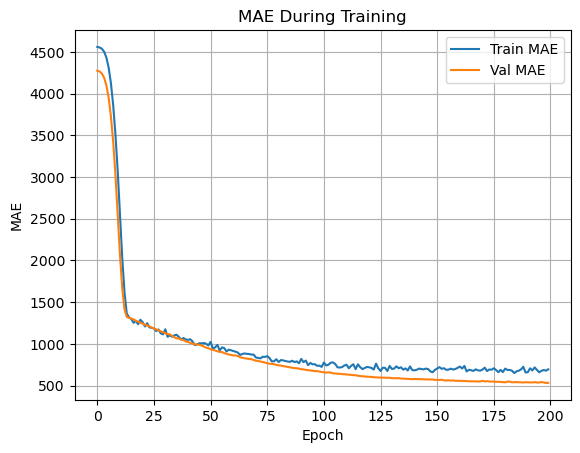

In [34]:
# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ensemble, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted: Ensemble")
plt.grid(True)
plt.show()

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MAE During Training")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Predict on training data
y_pred_nn_train = model.predict(X_train_processed).flatten()
y_pred_rf_train = rf.predict(X_train)
y_pred_ensemble_train = 0.5 * y_pred_nn_train + 0.5 * y_pred_rf_train

print("--- Evaluation on Training Data ---")
print("Neural Network Train MAE:", mean_absolute_error(y_train, y_pred_nn_train))
print("Random Forest Train MAE:", mean_absolute_error(y_train, y_pred_rf_train))
print("Ensemble Train MAE:", mean_absolute_error(y_train, y_pred_ensemble_train))
print("Ensemble Train R² Score:", r2_score(y_train, y_pred_ensemble_train))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--- Evaluation on Training Data ---
Neural Network Train MAE: 487.3140102151322
Random Forest Train MAE: 156.31785958904112
Ensemble Train MAE: 305.327318936962
Ensemble Train R² Score: 0.950593482998715
